# Imports 

In [1]:
import numpy as np
import ipynb.fs.full.PrepareData as data
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
import itertools

strategyArray = []
errorArray    = [[], []]

/home/leandro/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
  9%|▉         | 4/43 [00:00<00:01, 34.71it/s]

[200, 179, 219, 199, 209, 219, 1239, 1238, 976, 179, 809, 919, 219]
2 chs: 200 entries
3 chs: 179 entries
4 chs: 219 entries
5 chs: 199 entries
6 chs: 209 entries
7 chs: 219 entries
8 chs: 1239 entries
9 chs: 1238 entries
10 chs: 976 entries
15 chs: 179 entries
20 chs: 809 entries
30 chs: 919 entries
40 chs: 219 entries


 74%|███████▍  | 32/43 [00:07<00:03,  2.81it/s]

RANSACRegressor model failed to execute
RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).


 91%|█████████ | 39/43 [00:08<00:00,  4.33it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 21%|██        | 9/43 [00:01<00:04,  7.25it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 91%|█████████ | 39/43 [00:09<00:00,  4.40it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 88%|████████▊ | 38/43 [00:09<00:01,  2.77it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


 21%|██        | 9/43 [00:01<00:06,  5.66it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


 88%|████████▊ | 38/43 [00:07<00:00,  5.55it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'


100%|██████████| 43/43 [00:07<00:00,  5.59it/s]


# Sorting the dataset

In [2]:
sortedDict = {}
commonRegressors = data.commonRegressors

for regressor in commonRegressors:
    sortedDict[regressor] = 0
    
    for i in range(data.ampNumber):
        sortedDict[regressor] += data.finalList[i][regressor][0] + data.finalList[i][regressor][1]

sortedDict = dict(sorted(sortedDict.items(), key = lambda x : x[1]))
sortedDict = dict(itertools.islice(sortedDict.items(), 5))

print(sortedDict.keys())

dict_keys(['BaggingRegressor', 'LassoCV', 'GradientBoostingRegressor', 'ElasticNetCV', 'RandomForestRegressor'])


# Processing data

In [3]:
from sklearn.metrics import mean_absolute_error

def getMAE(yTrue, yPredicted):
    gainErrors = []
    lossErrors = []
    
    rangeList = list(range(len(yTrue[0])))
    
    for true, predicted in zip(yTrue, yPredicted):
        gainTrue      = [true[x] for x in rangeList[0::2]]
        gainPredicted = [predicted[x] for x in rangeList[0::2]]
        lossTrue      = [true[x] for x in rangeList[1::2]]
        lossPredicted = [predicted[x] for x in rangeList[1::2]]
        
        gainErrors.append(mean_absolute_error(gainTrue, gainPredicted))
        lossErrors.append(mean_absolute_error(lossTrue, lossPredicted))
        
    return gainErrors, lossErrors

# Plotting function

In [4]:
import matplotlib.pyplot as plt

def plotGrid(gainData, lossData):
    fig, axis = plt.subplots(2, figsize = (10, 10))
    #fig.suptitle("One regressor per link - {} amplifiers".format(data.ampNumber), fontsize = 20)
    
    axis[0].boxplot(gainData)
    axis[0].set_title("Gain test error", fontsize = 18)
    axis[0].xaxis.set_tick_params(labelsize = 14)
    axis[0].set_ylim(0, 5)
    
    axis[1].boxplot(lossData)
    axis[1].set_title("Loss test error", fontsize = 18)
    axis[1].xaxis.set_tick_params(labelsize = 14)
    axis[1].set_xticklabels(strategyArray, rotation = -45, ha = 'left')
    axis[1].set_ylim(0, 5)

    fig.text(0.08, 0.5, 'Mean Absolute error (dB)', va='center', rotation='vertical', fontsize = 18)

    plt.gcf().subplots_adjust(bottom = 0.15)
    fig.savefig("../../graphs/perLink-{}amps.eps".format(data.ampNumber), format = 'eps', dpi = 1000, bbox_inches = "tight")

# Building the models

In [5]:
X, y = data.loadDataset()
X_train, X_test, y_train, y_test = data.train_test_split(X, y, test_size = 0.3, random_state = 0)

count = 1

In [6]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor

extra_tree = ExtraTreeRegressor(criterion = "mse", random_state=0)
model      = MultiOutputRegressor(BaggingRegressor(base_estimator = extra_tree,
                                                   random_state   = 0))

param_grid = {
    'estimator__n_estimators': [5, 50, 100],
    'estimator__base_estimator__max_leaf_nodes': [None, 5, 50, 100],
    'estimator__base_estimator__splitter': ['random', 'best']
}

grid = GridSearchCV(model, param_grid=param_grid)
grid.fit(X_train, y_train)

model = grid.best_estimator_
model.fit(X_train, y_train)

result = model.predict(X_test)

strategyArray.append("{} - BaggingRegressor".format(count))
result = getMAE(y_test, result)

errorArray[0].append(result[0])
errorArray[1].append(result[1])

count += 1
print("Gain error: {} +- {}".format(np.mean(result[0]), np.std(result[0])))
print("Loss error: {} +- {}".format(np.mean(result[1]), np.std(result[1])))

Gain error: 1.4196218543754615 +- 0.8889070738719997
Loss error: 1.3821600244275627 +- 0.8451229936467254


In [7]:
from sklearn.linear_model import LassoCV

model = MultiOutputRegressor(LassoCV())

param_grid = {
    'estimator__cv': [5, 10],
    'estimator__selection': ['cyclic', 'random'],
    'estimator__alphas': [np.logspace(-4, -0.5, 30)]
}

grid = GridSearchCV(model, param_grid=param_grid)
grid.fit(X_train, y_train)

model = grid.best_estimator_
model.fit(X_train, y_train)

result = model.predict(X_test)

strategyArray.append("{} - LassoCV".format(count))
result = getMAE(y_test, result)

errorArray[0].append(result[0])
errorArray[1].append(result[1])

count += 1
print("Gain error: {} +- {}".format(np.mean(result[0]), np.std(result[0])))
print("Loss error: {} +- {}".format(np.mean(result[1]), np.std(result[1])))

Gain error: 1.4187749086482024 +- 0.8911274589886046
Loss error: 1.385755103845102 +- 0.848449415051587


In [8]:
from sklearn.ensemble import GradientBoostingRegressor

model = MultiOutputRegressor(GradientBoostingRegressor())

param_grid = {
    'estimator__learning_rate': [.1, .5, .7, 1],
    'estimator__n_estimators': [10, 50, 100],
    'estimator__subsample': [.1, .5, .7, 1]
}

grid = GridSearchCV(model, param_grid=param_grid)
grid.fit(X_train, y_train)

model = grid.best_estimator_
model.fit(X_train, y_train)

result = model.predict(X_test)

strategyArray.append("{} - GradientBoostingRegressor".format(count))
result = getMAE(y_test, result)

errorArray[0].append(result[0])
errorArray[1].append(result[1])

count += 1
print("Gain error: {} +- {}".format(np.mean(result[0]), np.std(result[0])))
print("Loss error: {} +- {}".format(np.mean(result[1]), np.std(result[1])))

Gain error: 1.4198480294541913 +- 0.8882664163126213
Loss error: 1.3818445727831918 +- 0.8504211355264621


In [9]:
from sklearn.linear_model import ElasticNetCV

model = MultiOutputRegressor(ElasticNetCV())

param_grid = {
    'estimator__selection': ['cyclic', 'random'],
    'estimator__l1_ratio': [.1, .5, .7, 1]
}

grid = GridSearchCV(model, param_grid=param_grid)
grid.fit(X_train, y_train)

model = grid.best_estimator_
model.fit(X_train, y_train)

result = model.predict(X_test)

strategyArray.append("{} - ElasticNetCV".format(count))
result = getMAE(y_test, result)

errorArray[0].append(result[0])
errorArray[1].append(result[1])

count += 1
print("Gain error: {} +- {}".format(np.mean(result[0]), np.std(result[0])))
print("Loss error: {} +- {}".format(np.mean(result[1]), np.std(result[1])))

Gain error: 1.4228504151511419 +- 0.8911329196148114
Loss error: 1.388726519381948 +- 0.8483924062917654


In [10]:
from sklearn.ensemble import RandomForestRegressor

model = MultiOutputRegressor(RandomForestRegressor())

param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__min_samples_split': [1, 3, 4, 5],
    'estimator__max_leaf_nodes': [None, 1, 5, 10]
}

grid = GridSearchCV(model, param_grid=param_grid)
grid.fit(X_train, y_train)

model = grid.best_estimator_
model.fit(X_train, y_train)

result = model.predict(X_test)

strategyArray.append("{} - RandomForestRegressor".format(count))
result = getMAE(y_test, result)

errorArray[0].append(result[0])
errorArray[1].append(result[1])

count += 1
print("Gain error: {} +- {}".format(np.mean(result[0]), np.std(result[0])))
print("Loss error: {} +- {}".format(np.mean(result[1]), np.std(result[1])))

Gain error: 1.4184361878002305 +- 0.8859013994908113
Loss error: 1.3813669920739604 +- 0.8501143262941225


In [11]:
from sklearn.dummy import DummyRegressor

model = MultiOutputRegressor(DummyRegressor())

model.fit(X_train, y_train)

result = model.predict(X_test)

strategyArray.append("{} - DummyRegressor".format(count))
result = getMAE(y_test, result)

errorArray[0].append(result[0])
errorArray[1].append(result[1])

count += 1
print("Gain error: {} +- {}".format(np.mean(result[0]), np.std(result[0])))
print("Loss error: {} +- {}".format(np.mean(result[1]), np.std(result[1])))

Gain error: 2.4131867919421572 +- 1.1865646456219878
Loss error: 1.7854367242779263 +- 0.9683626615293187


dict_keys(['BaggingRegressor', 'LassoCV', 'GradientBoostingRegressor', 'ElasticNetCV', 'RandomForestRegressor'])


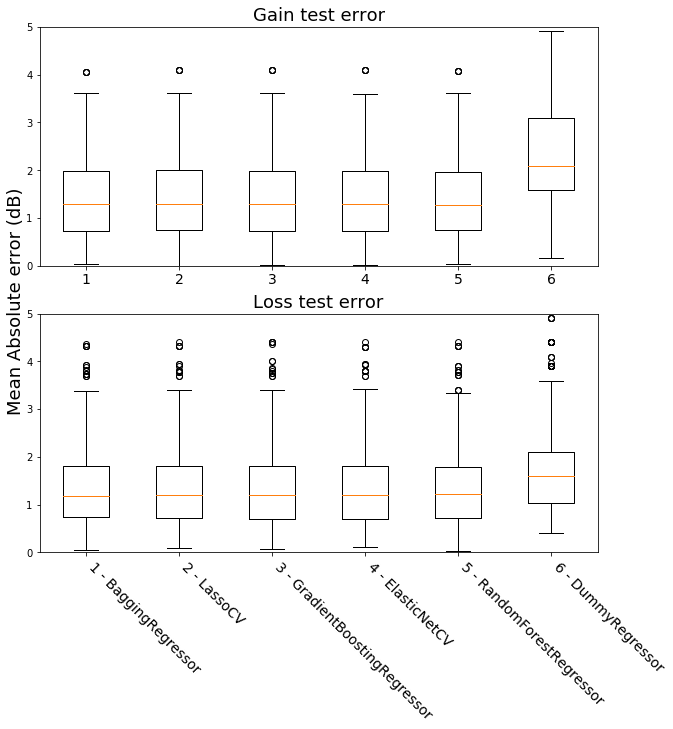

In [12]:
print(sortedDict.keys())
plotGrid(errorArray[0],errorArray[1])